In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageFilter
import io
import torch

import sys
import patcher
import gc
import yaml

sys.path.append("../")


def clear_gpu() -> None:
    torch.clear_autocast_cache()
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    gc.collect()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = torch.Generator()
gen.manual_seed(0)


def dump_to_pickle(data, file_path: str):
    try:
        with open(file_path, "wb") as file:
            pickle.dump(data, file)
        print(f"Data successfully dumped to {file_path}")
    except Exception as e:
        print(f"An error occurred while dumping data: {e}")


def load_from_pickle(file_path: str):
    try:
        with open(file_path, "rb") as file:
            data = pickle.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except Exception as e:
        print(f"An error occurred while loading data: {e}")
        return None


# img_frs_seq = load_from_pickle("img_frs_seq.pkl")[:10]
# msk_frs_seq = load_from_pickle("msk_frs_seq.pkl")[:10]
# stylized = load_from_pickle("stylized.pkl")[:10]
# memo_flows_fwd = load_from_pickle("memo_flows_fwd.pkl")[:10]
# memo_flows_bwd = load_from_pickle("memo_flows_bwd.pkl")[:10]

img_frs_ts = load_from_pickle("img_frs_ts.pkl")[:12]
stl_frs_ts = load_from_pickle("stl_frs_ts.pkl")[:12]
# msk_frs_ts = load_from_pickle("msk_frs_ts.pkl")
stl_frames = torch.cat(
    [
        stl_frs_ts[0].unsqueeze(0),
        stl_frs_ts[5].unsqueeze(0),
        stl_frs_ts[11].unsqueeze(0),
    ]
)


j:\AI\ComfyUI_windows_portable\python_embeded\Lib\site-packages\transformers\utils\hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Data successfully loaded from img_frs_ts.pkl
Data successfully loaded from stl_frs_ts.pkl


In [115]:
# img_frs_ts = patcher.np_to_tensor(img_frs_seq)
# stl_frs_ts = patcher.np_to_tensor(stylized)
# msk_frs_ts = patcher.np_msk_to_tensor(msk_frs_seq)
# dump_to_pickle(img_frs_ts, "img_frs_ts.pkl")
# dump_to_pickle(stl_frs_ts, "stl_frs_ts.pkl")
# dump_to_pickle(msk_frs_ts, "msk_frs_ts.pkl")



In [50]:
2**5

32

In [14]:

stl_frs_ts.dtype

torch.float64

In [2]:
cfg_path = "J:/AI/sanct/PatchBased-StyleTransfer/config/reference_P.yaml"
with open(cfg_path, "r") as f:
    job_description = yaml.full_load(f)

(
    generator,
    opt_generator,
    discriminator,
    opt_discriminator,
    perception_loss_model,
    perception_loss_weight,
    reconstruction_criterion,
    adversarial_criterion,
) = patcher.init_model(job_description, device)


In [19]:
clear_gpu()

In [18]:
patcher.train(
    org_frames=img_frs_ts.float(),
    stl_frames=stl_frames.float(),
    stl_indices=[0, 5, 11],
    generator=generator,
    opt_generator = opt_generator,
    discriminator = discriminator,
    opt_discriminator = opt_discriminator,
    perception_loss_model = perception_loss_model,
    reconstruction_criterion = reconstruction_criterion,
    adversarial_criterion = adversarial_criterion,
    device = device,
    num_epochs = 40,
    batch_size=32,
    patch_size=128
)

# G[3.88530] D[0.00257] (10)
# G[3.30539] D[0.04168] (40)

Training epoch [40] G[3.30539] D[0.04168]: 100%|██████████| 41/41 [01:23<00:00,  2.03s/it]


In [11]:
train_dataset = patcher.DatasetPatches_M(
    org_frames=img_frs_ts,
    stl_frames=stl_frames,
    stl_indices=[0, 5, 11],
    msk_frames=None,
    flw_fwds=None,
    flw_bwds=None,
)


In [4]:
indices = patcher.get_valid_indices(540, 960, 128, 0)
test_patches = patcher.cut_patches(img_frs_ts[1], indices, 128, 0)
input_batches = torch.split(test_patches, 32)

In [5]:
test_patches.shape

torch.Size([28, 3, 128, 128])

In [11]:
input_batches = torch.split(test_patches, 64)

In [14]:
len(input_batches)

8

In [20]:
outs = [generator.forward(bat.float().to(device)) for bat in input_batches]
out_cat = torch.cat(outs, dim=0)
rec = patcher.reconstruct_image(out_cat, indices, (3, 540, 960))

In [13]:
def display(image: torch.Tensor):
    # Convert the tensor to a numpy array and transpose it to [H, W, C]
    image_np = image.permute(1, 2, 0).numpy()

    # Display the image using matplotlib
    plt.imshow(image_np)
    plt.axis('off')  # Hide the axis
    plt.show()

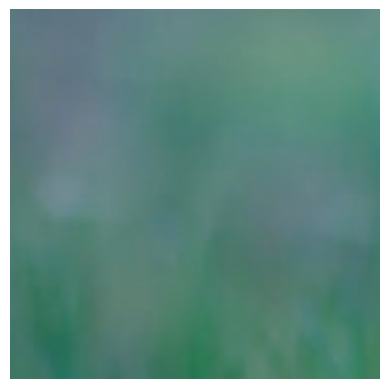

In [61]:
display(test_patches[143])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13547766..1.0].


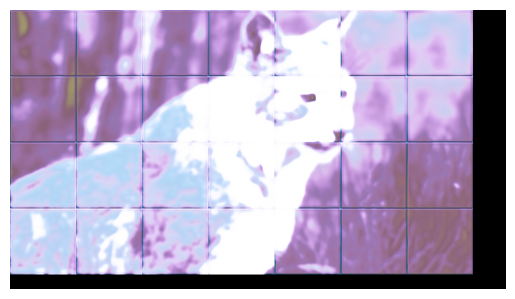

In [21]:
display(rec.detach().cpu())

In [52]:
from torch.utils.data import Dataset, DataLoader


In [120]:
patch_loader = DataLoader(train_dataset, 1, shuffle=False)


In [121]:
first_inp, first_gt = None, None
for i, (input_patches, gt_patches) in enumerate(patch_loader):
    print(f"Batch {i}:")
    print(f"{input_patches.shape=}")
    first_inp, first_gt = input_patches, gt_patches
    # print(f"{gt_patches.shape=}")
    break
    # if i >= 9:  # This will print the first 10 batches
    #     break


item=0
Batch 0:
input_patches.shape=torch.Size([1, 464, 3, 32, 32])


In [105]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models


class UpsamplingLayer(nn.Module):
    def __init__(self, channels):
        super(UpsamplingLayer, self).__init__()
        self.layer = nn.Upsample(scale_factor=2)

    def forward(self, x):
        return self.layer(x)


In [112]:
class GeneratorJ(nn.Module):
    def __init__(
        self,
        input_size=256,
        norm_layer="batch_norm",
        gpu_ids=None,
        use_bias=False,
        resnet_blocks=9,
        tanh=False,
        filters=(64, 128, 128, 128, 128, 64),
        input_channels=3,
        append_smoothers=False,
    ):
        super(GeneratorJ, self).__init__()
        self.input_size = input_size
        assert norm_layer in [
            None,
            "batch_norm",
            "instance_norm",
        ], "norm_layer should be None, 'batch_norm' or 'instance_norm', not {}".format(
            norm_layer
        )
        self.norm_layer = None
        if norm_layer == "batch_norm":
            self.norm_layer = nn.BatchNorm2d
        elif norm_layer == "instance_norm":
            self.norm_layer = nn.InstanceNorm2d
        self.gpu_ids = gpu_ids
        self.use_bias = use_bias
        self.resnet_blocks = resnet_blocks
        self.append_smoothers = append_smoothers

        self.conv0 = self.relu_layer(
            in_filters=input_channels,
            out_filters=filters[0],
            size=7,
            stride=1,
            padding=3,
            bias=self.use_bias,
            norm_layer=self.norm_layer,
            nonlinearity=nn.LeakyReLU(0.2),
        )

        self.conv1 = self.relu_layer(
            in_filters=filters[0],
            out_filters=filters[1],
            size=3,
            stride=2,
            padding=1,
            bias=self.use_bias,
            norm_layer=self.norm_layer,
            nonlinearity=nn.LeakyReLU(0.2),
        )

        self.conv2 = self.relu_layer(
            in_filters=filters[1],
            out_filters=filters[2],
            size=3,
            stride=2,
            padding=1,
            bias=self.use_bias,
            norm_layer=self.norm_layer,
            nonlinearity=nn.LeakyReLU(0.2),
        )

        self.resnets = nn.ModuleList()
        for i in range(self.resnet_blocks):
            self.resnets.append(
                self.resnet_block(
                    in_filters=filters[2],
                    out_filters=filters[2],
                    size=3,
                    stride=1,
                    padding=1,
                    bias=self.use_bias,
                    norm_layer=self.norm_layer,
                    nonlinearity=nn.ReLU(),
                )
            )

        self.upconv2 = self.upconv_layer_upsample_and_conv(
            in_filters=filters[3] + filters[2],
            # in_filters=filters[3], # disable skip-connections
            out_filters=filters[4],
            size=4,
            stride=2,
            padding=1,
            bias=self.use_bias,
            norm_layer=self.norm_layer,
            nonlinearity=nn.ReLU(),
        )

        self.upconv1 = self.upconv_layer_upsample_and_conv(
            in_filters=filters[4] + filters[1],
            # in_filters=filters[4],  # disable skip-connections
            out_filters=filters[4],
            size=4,
            stride=2,
            padding=1,
            bias=self.use_bias,
            norm_layer=self.norm_layer,
            nonlinearity=nn.ReLU(),
        )

        self.conv_11 = nn.Sequential(
            nn.Conv2d(
                in_channels=filters[0] + filters[4] + input_channels,
                # in_channels=filters[4],  # disable skip-connections
                out_channels=filters[5],
                kernel_size=7,
                stride=1,
                padding=3,
                bias=self.use_bias,
            ),
            nn.ReLU(),
        )

        if self.append_smoothers:
            self.conv_11_a = nn.Sequential(
                nn.Conv2d(
                    filters[5], filters[5], kernel_size=3, bias=self.use_bias, padding=1
                ),
                nn.ReLU(),
                nn.BatchNorm2d(num_features=filters[5]),  # replace with variable
                nn.Conv2d(
                    filters[5], filters[5], kernel_size=3, bias=self.use_bias, padding=1
                ),
                nn.ReLU(),
            )

        if tanh:
            self.conv_12 = nn.Sequential(
                nn.Conv2d(filters[5], 3, kernel_size=1, stride=1, padding=0, bias=True),
                nn.Tanh(),
            )
        else:
            self.conv_12 = nn.Conv2d(
                filters[5], 3, kernel_size=1, stride=1, padding=0, bias=True
            )

    def forward(self, x):
        print(f"{x.dtype=}")
        output_0 = self.conv0(x)
        output_1 = self.conv1(output_0)
        output = self.conv2(output_1)
        output_2 = self.conv2(output_1)  # comment to disable skip-connections
        for layer in self.resnets:
            output = layer(output) + output

        # output = self.upconv2(output)  # disable skip-connections
        # output = self.upconv1(output)  # disable skip-connections
        # output = self.conv_11(output)  # disable skip-connections
        output = self.upconv2(torch.cat((output, output_2), dim=1))
        output = self.upconv1(torch.cat((output, output_1), dim=1))
        output = self.conv_11(torch.cat((output, output_0, x), dim=1))

        if self.append_smoothers:
            output = self.conv_11_a(output)
        output = self.conv_12(output)
        return output

    def relu_layer(
        self,
        in_filters,
        out_filters,
        size,
        stride,
        padding,
        bias,
        norm_layer,
        nonlinearity,
    ):
        out = nn.Sequential()
        out.add_module(
            "conv",
            nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=size,
                stride=stride,
                padding=padding,
                bias=bias,
            ),
        )
        if norm_layer:
            out.add_module("normalization", norm_layer(num_features=out_filters))
        if nonlinearity:
            out.add_module("nonlinearity", nonlinearity)
        return out

    def resnet_block(
        self,
        in_filters,
        out_filters,
        size,
        stride,
        padding,
        bias,
        norm_layer,
        nonlinearity,
    ):
        out = nn.Sequential()
        if nonlinearity:
            out.add_module("nonlinearity_0", nonlinearity)
        out.add_module(
            "conv_0",
            nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=size,
                stride=stride,
                padding=padding,
                bias=bias,
            ),
        )
        if norm_layer:
            out.add_module("normalization", norm_layer(num_features=out_filters))
        if nonlinearity:
            out.add_module("nonlinearity_1", nonlinearity)
        out.add_module(
            "conv_1",
            nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=size,
                stride=stride,
                padding=padding,
                bias=bias,
            ),
        )
        return out

    def upconv_layer(
        self,
        in_filters,
        out_filters,
        size,
        stride,
        padding,
        bias,
        norm_layer,
        nonlinearity,
    ):
        out = nn.Sequential()
        out.add_module(
            "upconv",
            nn.ConvTranspose2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=size,  # 4
                stride=stride,  # 2
                padding=padding,
                bias=bias,
            ),
        )
        if norm_layer:
            out.add_module("normalization", norm_layer(num_features=out_filters))
        if nonlinearity:
            out.add_module("nonlinearity", nonlinearity)
        return out

    def upconv_layer_upsample_and_conv(
        self,
        in_filters,
        out_filters,
        size,
        stride,
        padding,
        bias,
        norm_layer,
        nonlinearity,
    ):
        parts = [
            UpsamplingLayer(in_filters),
            nn.Conv2d(in_filters, out_filters, 3, 1, 1, bias=False),
        ]

        if norm_layer:
            parts.append(norm_layer(num_features=out_filters))

        if nonlinearity:
            parts.append(nonlinearity)

        return nn.Sequential(*parts)


In [122]:
generator = GeneratorJ(
    input_size=256,
    norm_layer="batch_norm",
    use_bias=True,
    resnet_blocks=7,
    filters=[32, 64, 128, 128, 128, 64],
    input_channels=3,
    append_smoothers=True,
)


In [ ]:
first_inp, first_gt


In [124]:
first_inp.dtype


torch.float32

In [126]:
gen_out = generator.forward(first_inp.squeeze())  # [N, C, H, W]


x.dtype=torch.float32


In [128]:
gen_out.shape


torch.Size([464, 3, 32, 32])